# Repulsive Energy Training

## 1.1 Setting up the environment

In [414]:
import torch
from tbmalt.physics.dftb.feeds import RepulsiveSplineFeed
from tbmalt.ml.loss_function import Loss, mse_loss


Tensor = torch.Tensor

# This must be set until typecasting from HDF5 databases has been implemented.
torch.set_default_dtype(torch.float64)

## 1.2 Setting up the molecular systems for training

In [415]:

# Reference of target properties
targets = {'repulsive_energy': torch.tensor([0.0727])}


## 1.3 Setting up the model for training

In [416]:

# Number of training cycles
number_of_epochs = 5000

# Learning rate
lr = 0.1

# Loss function
loss_func = mse_loss

In [417]:
from __future__ import annotations
import warnings
# from itertools import combinations_with_replacement # No longer needed for from_database
from typing import List, Literal, Optional, Dict, Tuple, Union, Type
import torch
from torch import Tensor
from tbmalt import Geometry
# from tbmalt.io.skf import Skf # No longer needed for Skf.RSpline
from tbmalt.ml import Feed

class RepulsiveSplineFeed(Feed):
    r"""Repulsive Feed for DFTB-like calculations using a custom pairwise potential.

    This class calculates repulsive energy based on effective nuclear charges (Z_eff)
    and parameters (alpha) for pairs of atoms.
    The original spline-based calculation is replaced by the new formula.

    Arguments:
        Z_eff_map: Dictionary mapping atomic numbers (int) to their effective
                   nuclear charge (float or Tensor).
        alpha_map: Dictionary mapping atomic numbers (int) to their alpha
                   parameter (float or Tensor).
        device: Device on which the feed object and its contents reside.
        dtype: Floating point dtype to be used for tensors.
    """

    def __init__(self, 
                 Z_eff_map: Dict[int, Union[float, Tensor]], 
                 alpha_map: Dict[int, Union[float, Tensor]],
                 device: Optional[torch.device] = None,
                 dtype: Optional[torch.dtype] = torch.float64):
        super().__init__()

        self._device = device if device is not None else torch.device('cpu')
        self._dtype = dtype if dtype is not None else torch.float64

        self.Z_eff_map = {
            k: (v if isinstance(v, Tensor) else torch.tensor(v, device=self._device, dtype=self._dtype))
            for k, v in Z_eff_map.items()
        }
        self.alpha_map = {
            k: (v if isinstance(v, Tensor) else torch.tensor(v, device=self._device, dtype=self._dtype))
            for k, v in alpha_map.items()
        }

        # Ensure all tensors in maps are on the correct device and dtype
        for Z_map_k in self.Z_eff_map:
            if self.Z_eff_map[Z_map_k].device != self._device or self.Z_eff_map[Z_map_k].dtype != self._dtype:
                self.Z_eff_map[Z_map_k] = self.Z_eff_map[Z_map_k].to(device=self._device, dtype=self._dtype)
        for alpha_map_k in self.alpha_map:
            if self.alpha_map[alpha_map_k].device != self._device or self.alpha_map[alpha_map_k].dtype != self._dtype:
                 self.alpha_map[alpha_map_k] = self.alpha_map[alpha_map_k].to(device=self._device, dtype=self._dtype)


        warnings.warn(
            "The `RepulsiveSplineFeed` class is now deprecated and will be "
            "removed. Its repulsive calculation logic has been changed from splines "
            "to a custom pairwise potential. Consider using a more appropriately named "
            "class or `PairwiseRepulsiveEnergyFeed` with a custom potential function.",
            category=DeprecationWarning)

    @property
    def dtype(self) -> torch.dtype:
        """Floating point dtype used by `RepulsiveSplineFeed` object."""
        return self._dtype

    @property
    def device(self) -> torch.device:
        """The device on which the `RepulsiveSplineFeed` object resides."""
        return self._device

    def __call__(self, geo: Geometry) -> Tensor:
        r"""Calculate the repulsive energy of a Geometry.

        Arguments:
            geo: `Geometry` object representing the system, or batch thereof,
                for which the repulsive energy should be calculated.

        Returns:
            Erep: The repulsive energy of the Geometry object(s).
        """
        batch_size, _, indx_pairs, _ = self._calculation_prep(geo)
        
        Erep = torch.zeros((batch_size), device=self.device, dtype=self.dtype)
        
        for indx_pair in indx_pairs:
            # Ensure indices are integers for geo.atomic_numbers access
            idx0, idx1 = int(indx_pair[0]), int(indx_pair[1])

            atomnum1_all = geo.atomic_numbers[..., idx0].reshape((batch_size, ))
            atomnum2_all = geo.atomic_numbers[..., idx1].reshape((batch_size, ))
            distance_all = geo.distances[..., idx0, idx1].reshape((batch_size, ))

            for batch_indx in range(batch_size):
                atomnum1 = int(atomnum1_all[batch_indx].item())
                atomnum2 = int(atomnum2_all[batch_indx].item())
                distance = distance_all[batch_indx]

                if atomnum1 == 0 or atomnum2 == 0: # Skip dummy atoms
                    continue
                
                # Retrieve parameters for the specific atom pair
                try:
                    Z_A_eff = self.Z_eff_map[atomnum1]
                    Z_B_eff = self.Z_eff_map[atomnum2]
                    alpha_A = self.alpha_map[atomnum1]
                    alpha_B = self.alpha_map[atomnum2]
                except KeyError as e:
                    raise KeyError(f"Missing Z_eff or alpha parameter for atomic number {e} in maps.") from e

                add_Erep = self._repulsive_calc(distance, Z_A_eff, Z_B_eff, alpha_A, alpha_B, grad=False)
                Erep[batch_indx] += add_Erep
        return Erep

    def gradient(self, geo: Geometry) -> Tensor:
        """Calculate the gradient of the repulsive energy.

        Arguments:
            geo: `Geometry` object representing the system, or batch thereof,
                for which the gradient of the repulsive energy should be
                calculated.

        returns:
            dErep: The gradient of the repulsive energy.
        """
        batch_size, _, indx_pairs, normed_distance_vectors = self._calculation_prep(geo)
        
        dErep = torch.zeros((batch_size, geo.atomic_numbers.size(dim=-1), 3), device=self.device, dtype=self.dtype)
        
        for indx_pair in indx_pairs:
            # Ensure indices are integers
            idx0, idx1 = int(indx_pair[0]), int(indx_pair[1])

            atomnum1_all = geo.atomic_numbers[..., idx0].reshape((batch_size, ))
            atomnum2_all = geo.atomic_numbers[..., idx1].reshape((batch_size, ))
            distance_all = geo.distances[..., idx0, idx1].reshape((batch_size, ))

            for batch_indx in range(batch_size):
                atomnum1 = int(atomnum1_all[batch_indx].item())
                atomnum2 = int(atomnum2_all[batch_indx].item())
                distance = distance_all[batch_indx]

                if atomnum1 == 0 or atomnum2 == 0: # Skip dummy atoms
                    continue

                try:
                    Z_A_eff = self.Z_eff_map[atomnum1]
                    Z_B_eff = self.Z_eff_map[atomnum2]
                    alpha_A = self.alpha_map[atomnum1]
                    alpha_B = self.alpha_map[atomnum2]
                except KeyError as e:
                    raise KeyError(f"Missing Z_eff or alpha parameter for atomic number {e} in maps.") from e
                
                # Calculate dE/dR (scalar derivative)
                scalar_grad_Erep = self._repulsive_calc(
                    distance, Z_A_eff, Z_B_eff, alpha_A, alpha_B, grad=True)
                
                # Get normalized distance vector for this pair in this batch item
                # Ensure normed_distance_vectors access is correct for batch_indx
                norm_vec_ij = normed_distance_vectors[batch_indx, idx0, idx1]
                norm_vec_ji = normed_distance_vectors[batch_indx, idx1, idx0] # Should be -norm_vec_ij

                # Distribute gradient to atoms: dE/dr_i = (dE/dR) * (dr/dr_i) = (dE/dR) * u_ij
                # Force on atom i is -dE/dr_i
                # Gradient component for atom i is (dE/dR) * u_ij
                # Gradient component for atom j is (dE/dR) * u_ji = (dE/dR) * (-u_ij)
                dErep[batch_indx, idx0] += scalar_grad_Erep * norm_vec_ij
                dErep[batch_indx, idx1] += scalar_grad_Erep * norm_vec_ji
        
        if batch_size == 1 and dErep.shape[0] == 1: # Ensure squeeze is safe
            dErep = dErep.squeeze(0)
        return dErep

    def _calculation_prep(self, geo: Geometry
                          ) -> Tuple[int, Tensor, Tensor, Tensor]:
        """Preliminaries for repulsive energy & gradient calculation.

        Arguments:
            geo: `Geometry` object representing the system, or batch thereof,
                for which the calculation preparation steps are to be performed.

        returns:
            batch_size: The number of geometries in the batch.
            indxs: The indices of the atoms.
            indx_pairs: The indices of the interacting atom pairs as tuples.
            normed_distance_vectors: The normalized distance vectors between the atoms
        """
        if geo.atomic_numbers.dim() == 1: # this means it is not a batch
            atomic_numbers_batched = geo.atomic_numbers.unsqueeze(0)
            if geo.distances.dim() == 2: # (n_atoms, n_atoms)
                 distances_batched = geo.distances.unsqueeze(0)
                 distance_vectors_batched = geo.distance_vectors.unsqueeze(0)
            else: # already (1, n_atoms, n_atoms)
                 distances_batched = geo.distances
                 distance_vectors_batched = geo.distance_vectors
            batch_size = 1
        else:
            atomic_numbers_batched = geo.atomic_numbers
            distances_batched = geo.distances
            distance_vectors_batched = geo.distance_vectors
            batch_size = atomic_numbers_batched.size(dim=0)

        n_atoms = atomic_numbers_batched.size(dim=-1)
        indxs = torch.arange(n_atoms, device=self.device) # Use self.device
        # combinations creates pairs like (0,1), (0,2), (1,2) etc.
        # It's important that these indices match how geo.distances are indexed.
        # geo.distances[..., i, j] is distance between atom i and atom j.
        indx_pairs = torch.combinations(indxs, r=2)


        # Handle division by zero for distances if atoms are at the same position
        # Add a small epsilon to distances in denominator to prevent NaN in normed_distance_vectors
        epsilon_dist = torch.tensor(1e-12, device=distances_batched.device, dtype=distances_batched.dtype)
        # This is R_AB, shape (batch_size, n_atoms, n_atoms)
        safe_distances = torch.max(distances_batched, epsilon_dist)

        # normed_distance_vectors shape (batch_size, n_atoms, n_atoms, 3)
        normed_distance_vectors = distance_vectors_batched / safe_distances.unsqueeze(-1)
        
        # Where original distance was truly zero, the vector was [0,0,0], so 0/epsilon resulted in 0.
        # If distance_vectors was [0,0,0] and distances was 0, then 0/epsilon is 0.
        # If distance_vectors was non-zero (should not happen if distance is 0) and distance was 0, then non-zero/epsilon.
        # A more robust way if distances_batched can be zero:
        # zero_dist_mask = (distances_batched == 0.0)
        # normed_distance_vectors[zero_dist_mask.unsqueeze(-1).expand_as(distance_vectors_batched)] = 0.0
        # However, the above max(distances_batched, epsilon_dist) handles the division part.
        # If geo.distances[i,j] is 0, geo.distance_vectors[i,j,:] should also be [0,0,0].
        # So [0,0,0] / epsilon is [0,0,0]. This seems fine.

        # The original code had:
        # normed_distance_vectors = geo.distance_vectors / geo.distances.unsqueeze(-1)
        # normed_distance_vectors[normed_distance_vectors.isnan()] = 0
        # This is also a valid way to handle it. Using max with epsilon avoids NaNs from division by zero directly.

        # Reshape not strictly necessary if subsequent code uses (batch, N, N, 3) directly
        # but keeping if other parts rely on this specific view for normed_distance_vectors
        # The original reshape was:
        # normed_distance_vectors = torch.reshape(
        # normed_distance_vectors, (
        # batch_size, normed_distance_vectors.shape[-3], # n_atoms
        # normed_distance_vectors.shape[-2], # n_atoms
        # normed_distance_vectors.shape[-1])) # 3
        # This reshape is redundant if normed_distance_vectors is already (batch_size, n_atoms, n_atoms, 3)

        return batch_size, indxs, indx_pairs, normed_distance_vectors

    def _repulsive_calc(
            self, 
            distance: Tensor, 
            Z_A_eff: Tensor, 
            Z_B_eff: Tensor,
            alpha_A: Tensor, 
            alpha_B: Tensor, 
            grad: bool = False
        ) -> Tensor:
        """Calculate the repulsive energy or its derivative between two atoms.
        
        Formula: E_rep = (Z_A_eff * Z_B_eff / R_AB) + exp(-sqrt(alpha_A * alpha_B) * R_AB^k_f)
        where k_f = 1.5.

        Arguments:
            distance (R_AB): The distance between the two atoms.
            Z_A_eff: Effective nuclear charge of atom A.
            Z_B_eff: Effective nuclear charge of atom B.
            alpha_A: Alpha parameter for atom A.
            alpha_B: Alpha parameter for atom B.
            grad: If True, calculate and return the derivative dE_rep/dR_AB.
                  Otherwise, return E_rep.

        Returns:
            Repulsive energy or its derivative with respect to distance.
        """
        k_f = 1.5
        R_AB = distance # Use R_AB as the variable for clarity with the formula

        # Ensure alpha parameters are non-negative for sqrt
        # Assuming alpha values from map are already appropriate (e.g. >= 0)
        # Add a small epsilon to R_AB in division to prevent inf/NaN if R_AB can be zero.
        # However, standard torch division 1.0/0.0 = inf. Gradient of 1/R is -1/R^2.
        # If R_AB is truly 0.0, energy is infinite. Gradient is also infinite.
        # This is often the desired physical behavior at singularity.
        # Clamping can be used if finite values are strictly needed for R_AB -> 0.
        # For now, let torch handle potential infinities.
        
        # Term 1: Coulombic-like repulsion
        term1 = (Z_A_eff * Z_B_eff) / R_AB

        # Term 2: Exponential repulsion
        sqrt_alpha_prod = torch.sqrt(alpha_A * alpha_B) # Assuming alpha_A, alpha_B >= 0
        # R_AB ** k_f can be problematic if R_AB is negative, but distances are non-negative.
        # If R_AB = 0, R_AB ** k_f = 0 (for k_f > 0).
        exp_argument = -sqrt_alpha_prod * (R_AB ** k_f)
        term2 = torch.exp(exp_argument)

        if not grad:
            repulsive_energy = term1 * term2
            return repulsive_energy
        else:
            # Derivative of term1: d(C/R)/dR = -C/R^2
            grad_term1 = - (Z_A_eff * Z_B_eff) / (R_AB ** 2)

            # Derivative of term2: d(exp(-A * R^k_f))/dR
            # = exp(-A * R^k_f) * (-A * k_f * R^(k_f-1))
            # where A = sqrt(alpha_A * alpha_B)
            # R_AB**(k_f - 1.0): if R_AB=0 and k_f-1=0.5, this is 0.0.
            # If R_AB is very small, this derivative term dominates.
            # If R_AB is 0, and k_f-1 > 0, then R_AB**(k_f-1) is 0, so grad_term2 is 0.
            # This means at R_AB=0, only the Coulombic gradient remains ( انفجاری).
            
            # Check for R_AB == 0 to handle R_AB**(k_f-1) correctly
            # if R_AB is a tensor, direct comparison might be needed with tolerance or use torch.where
            if R_AB == 0.0: # Exact zero
                 # grad_term1 will be -inf or inf (or nan if Z_A_eff*Z_B_eff is also 0)
                 # grad_term2 contribution is 0 because R_AB**(k_f-1.0) = 0.0**(0.5) = 0.0
                 grad_term2 = torch.tensor(0.0, device=R_AB.device, dtype=R_AB.dtype)
            else:
                 grad_term2 = term2 * (-sqrt_alpha_prod * k_f * (R_AB ** (k_f - 1.0)))
            
            return grad_term1 * grad_term2

    @classmethod
    def from_database(
            cls, path: str, species: List[int],
            dtype: Optional[torch.dtype] = None,
            device: Optional[torch.device] = None
            ) -> 'RepulsiveSplineFeed':
        r"""Instantiate instance from a HDF5 database of Slater-Koster files.
        
        NOTE: This method is currently NOT IMPLEMENTED for the new repulsive
        potential form. The original `from_database` was designed to load
        spline data from SKF files. To use this class, you need to provide
        `Z_eff_map` and `alpha_map` directly to the constructor.
        """
        raise NotImplementedError(
            "from_database is not implemented for the current repulsive potential form. "
            "Please provide Z_eff_map and alpha_map directly to the constructor.")

## 1.4 Input the molecular systems

In [418]:
from tbmalt import Geometry, OrbitalInfo
shell_dict = {1: [0], 6: [0, 1], 7: [0, 1], 8: [0, 1]}

device = torch.device('cpu')
# Construct the `Geometry` and `OrbitalInfo` objects. The former is analogous
# to the ase.Atoms object while the latter provides information about what
# orbitals are present and which atoms they belong to.
geometry = Geometry(
        torch.tensor([8,1,1], device=device),
        torch.tensor([
            [0.00000000, -0.71603315, -0.00000000],
            [0.00000000, -0.14200298, 0.77844804 ],
            [-0.00000000, -0.14200298, -0.77844804]],
            device=device),units='a')

orbs = OrbitalInfo(geometry.atomic_numbers, shell_dict)

print('Geometry:', geometry)
print('OrbitalInfo:', orbs)

# Identify which species are present
species = torch.unique(geometry.atomic_numbers)
# Strip out padding species and convert to a standard list.
species = species[species != 0].tolist()

Geometry: Geometry(OH2)
OrbitalInfo: <tbmalt.structures.orbitalinfo.OrbitalInfo object at 0x7feff7ad5150>


## 3. Model training

In [ ]:
# Z_H_eff = 1.116244
z_effs = {
    1: torch.nn.Parameter(torch.rand(())),  # Hydrogen
    8: torch.tensor(5.171786)   # Oxygen
}
alphas = {
    1: torch.tensor(2.209700),  # Hydrogen
    8: torch.tensor(2.004253)   # Oxygen
}

parameter = z_effs[1]

In [420]:
optimizer = torch.optim.SGD([parameter], lr=lr)

In [421]:
loss_list = []

rep_feed = RepulsiveSplineFeed(Z_eff_map=z_effs, alpha_map=alphas, device=device, dtype=torch.float64)

for epoch in range(number_of_epochs):
    optimizer.zero_grad()

    rep_energy = 2 * rep_feed(geometry)
   
    loss = mse_loss(rep_energy, targets['repulsive_energy'])

    loss.backward()

    optimizer.step()

    print("loss:",loss)
    # Record loss
    loss_list.append(loss.item())

print("Final training parameters: Z_eff:", z_effs[1], "alpha:", alphas[1])

/tmp/ipykernel_1645/672218363.py:55: DeprecationWarning: The `RepulsiveSplineFeed` class is now deprecated and will be removed. Its repulsive calculation logic has been changed from splines to a custom pairwise potential. Consider using a more appropriately named class or `PairwiseRepulsiveEnergyFeed` with a custom potential function.
  warnings.warn(


RuntimeError: output with shape [] doesn't match the broadcast shape [1]

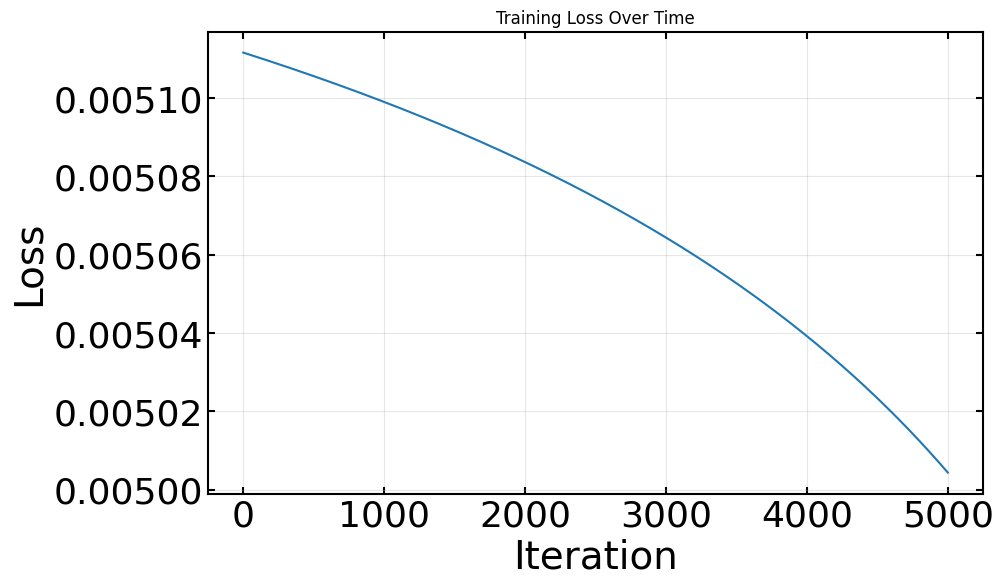

In [ ]:
# Plot the loss
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.linewidth"] = 1.5
plt.tick_params(direction='in', labelsize='26', width=1.5, length=5, top='on',
                right='on', zorder=10)
plt.plot(range(number_of_epochs), loss_list)
plt.xlabel("Iteration", fontsize=28)
plt.ylabel("Loss", fontsize=28)
plt.title("Training Loss Over Time")
plt.grid(True, alpha=0.3)
plt.show()
